In [35]:
import pandas as pd
from datetime import datetime
from pathlib import Path

# Paths
DAILY_FOLDER = Path("data/daily")
AVERAGE_FILE = Path("data/averages/average_hot_scores.csv")
OUTPUT_FOLDER = Path("output/runtime")
DATA_FOLDER = Path("data/runtime")
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)
DATA_FOLDER.mkdir(parents=True, exist_ok=True)

# Load latest daily CSV
daily_file = sorted(DAILY_FOLDER.glob("hot_stocks_*.csv"))[-1]
df_daily = pd.read_csv(daily_file)

# Load averages
df_avg = pd.read_csv(AVERAGE_FILE)

# Merge for comparison
df = df_daily.merge(df_avg[['symbol','HotScore']], on='symbol', how='left', suffixes=('_today','_avg'))

# Compute RuntimeScore (example)
df['RuntimeScore'] = 0.5*df['HotScore_today'] + 0.5*(df['HotScore_today']/df['HotScore_avg'])

# Filter top suggestions
top_runtime = df[df['RuntimeScore'] > df['RuntimeScore'].quantile(0.8)].sort_values('RuntimeScore', ascending=False)

# Save CSV with timestamp
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
csv_file = DATA_FOLDER / f"runtime_suggestions_{timestamp}.csv"
top_runtime.to_csv(csv_file, index=False)
top_runtime['symbol'].tolist()


['URBN',
 'HOOD',
 'ADSK',
 'MESO',
 'CRWV',
 'BLLN',
 'ARWR',
 'NBIX',
 'ORCL',
 'FLNC']

C:\Users\a73s\AppData\Local\Temp\ipykernel_20488\2748290681.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='symbol', y='RuntimeScore', data=top_runtime.head(20), palette='coolwarm', ax=ax)


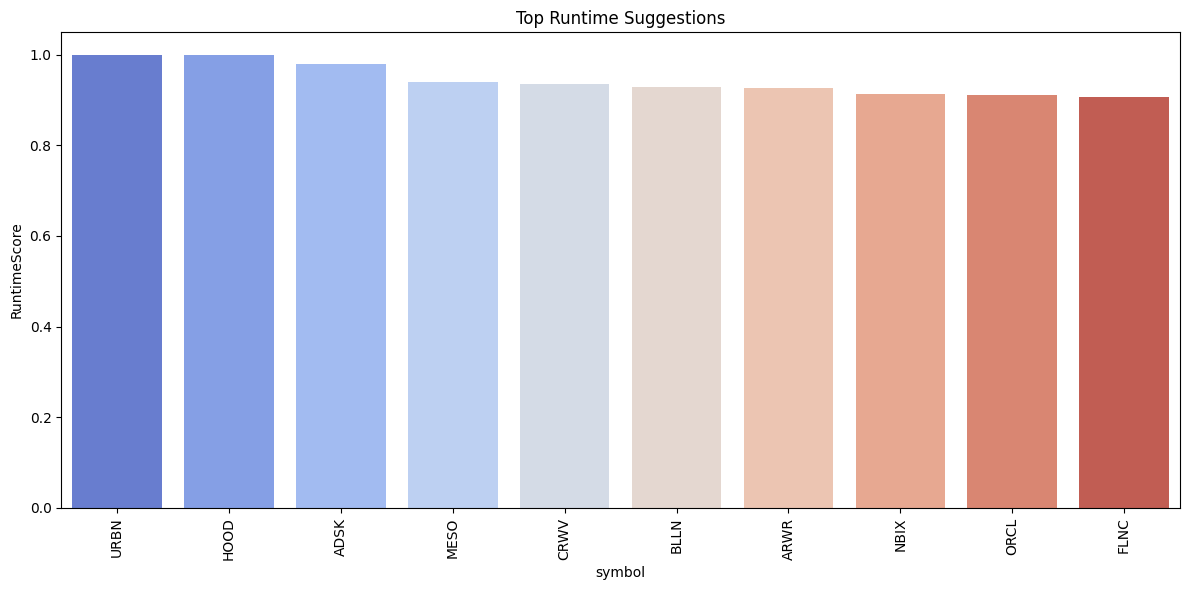

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='symbol', y='RuntimeScore', data=top_runtime.head(20), palette='coolwarm', ax=ax)
plt.xticks(rotation=90)
plt.title("Top Runtime Suggestions")
png_file = OUTPUT_FOLDER / f"runtime_top20_{timestamp}.png"
plt.tight_layout()
plt.savefig(png_file)
plt.show()
plt.close(fig)
